# Purpose
* Reproducing the [Figure 2.29 from MBML](https://www.mbmlbook.com/LearningSkills_Learning_the_guess_probabilities.html), shown below
* Iterations and experiments were driven by the [discussion found on the Pyro forum](https://forum.pyro.ai/t/log-probability-of-model/3241?u=bdatko)

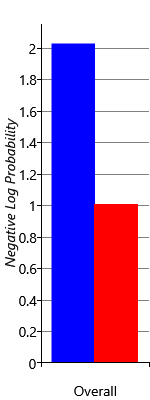
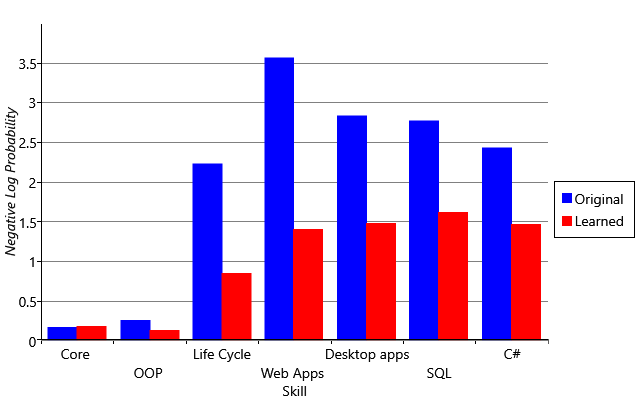
>**Figure 2.29**: (left) Overall negative log probability for the original model and the model with learned guess probabilities. The lower red bar indicates that learning the guess probabilities gives a substantially better model, according to this metric. (right) Negative log probability for each skill, showing that the improvement varies from skill to skill. 

* The figure is **not** the `log_density` of the model it is the negative log probability of the ground truth. For a participant with $skill_i$ the negative log probability is . 

$$-log(p(skill_i = truth_i))$$

where $truth_i$ is an indicator variable of having $skill_i$ and the probability of each skill is $p(skill_i)$ ~ $Bernoulli(\theta_i)$

Further details from the text:

> A common metric to use is the **probability of the ground truth** values under the inferred distributions. Sometimes it is convenient to take the logarithm of the probability, since this gives a more manageable number when the probability is very small. When we use the logarithm of the probability, the metric is referred to as the log probability. So, if the inferred probability of a person having a particular skill is $p$, then the log probability is $log(p)$ if the person has the skill and $log(1−p)$ if they don’t. If the person does have the skill then the best possible prediction is $p=1.0$, which gives log probability of $log(1.0)=0$ (the logarithm of one is zero). A less confident prediction, such as $p=0.8$ will give a log probability with a negative value, in this case $log(0.8)=−0.097$. The worst possible prediction of $p=0.0$ gives a log probability of negative infinity. ...

In [1]:
import operator
from functools import reduce
from typing import Dict, List

import arviz as az
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
from jax.scipy.special import logsumexp

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, DiscreteHMCGibbs, log_likelihood
from numpyro.infer.util import log_density, potential_energy

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%load_ext watermark

In [3]:
%watermark -v -m -p arviz,jax,matplotlib,numpy,pandas,scipy,numpyro

Python implementation: CPython
Python version       : 3.8.11
IPython version      : 7.18.1

arviz     : 0.11.2
jax       : 0.2.19
matplotlib: 3.4.3
numpy     : 1.20.3
pandas    : 1.3.2
scipy     : 1.6.2
numpyro   : 0.7.2

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 4.19.193-1-MANJARO
Machine     : x86_64
Processor   : 
CPU cores   : 4
Architecture: 64bit



In [4]:
%watermark -gb

Git hash: b87de17cc724f11acb7fc7d52700f9208ac82cb2

Git branch: master



In [5]:
def neg_log_proba_score(posterior_samples: Dict, params_sites: List[str], y_true):
    """
    Calculates the the negative log probability of the ground truth, the self assessed skills.
    :param posterior_samples Dict: dictionary of samples from the posterior.
    :param params_sites List[str]: a list of params to compute proba
    :y_true array-like dtype == int: array of indicator variables for skill of participants
    """
    assert np.issubdtype(y_true.dtype, np.integer)
    proba = np.zeros((len(params_sites), posterior_samples[params_sites[0]].shape[-1]))
    assert proba.shape == y_true.shape
    for i, param in enumerate(params_sites):
        proba[i, :] = np.mean(posterior_samples[param], axis=0)

    score = scipy.stats.bernoulli(proba).pmf(y_true)
    score[score == 0.0] = np.finfo(float).eps

    return -np.log(score)

In [6]:
rng_key = jax.random.PRNGKey(2)

### Get Data

In [7]:
raw_data = pd.read_csv(
    "http://www.mbmlbook.com/Downloads/LearningSkills_Real_Data_Experiments-Original-Inputs-RawResponsesAsDictionary.csv"
)
self_assessed = raw_data.iloc[1:, 1:8].copy()
self_assessed = self_assessed.astype(int)

skills_key = pd.read_csv(
    "http://www.mbmlbook.com/Downloads/LearningSkills_Real_Data_Experiments-Original-Inputs-Quiz-SkillsQuestionsMask.csv",
    header=None,
)
skills_needed = []
for index, row in skills_key.iterrows():
    skills_needed.append([i for i, x in enumerate(row) if x])

responses = pd.read_csv(
    "http://www.mbmlbook.com/Downloads/LearningSkills_Real_Data_Experiments-Original-Inputs-IsCorrect.csv",
    header=None,
)

responses = responses.astype("int32")

### Define models and run inference

In [8]:
def model_00(
    graded_responses, skills_needed: List[List[int]], prob_mistake=0.1, prob_guess=0.2
):
    n_questions, n_participants = graded_responses.shape
    n_skills = max(map(max, skills_needed)) + 1

    participants_plate = numpyro.plate("participants_plate", n_participants)

    with participants_plate:
        skills = []
        for s in range(n_skills):
            skills.append(numpyro.sample("skill_{}".format(s), dist.Bernoulli(0.5)))

    for q in range(n_questions):
        has_skills = reduce(operator.mul, [skills[i] for i in skills_needed[q]])
        prob_correct = has_skills * (1 - prob_mistake) + (1 - has_skills) * prob_guess
        isCorrect = numpyro.sample(
            "isCorrect_{}".format(q),
            dist.Bernoulli(prob_correct).to_event(1),
            obs=graded_responses[q],
        )

In [9]:
nuts_kernel = NUTS(model_00)

kernel = DiscreteHMCGibbs(nuts_kernel, modified=True)

mcmc_00 = MCMC(
    kernel, num_warmup=200, num_samples=1000, num_chains=4, jit_model_args=False
)
mcmc_00.run(
    rng_key,
    jnp.array(responses),
    skills_needed,
    extra_fields=(
        "z",
        "hmc_state.potential_energy",
        "hmc_state.z",
        "rng_key",
        "hmc_state.rng_key",
    ),
)
mcmc_00.print_summary()

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 1200/1200 [02:00<00:00,  9.94it/s, 1 steps of size 1.19e+37. acc. prob=1.00] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
 skill_0[0]      1.00      0.00      1.00      1.00      1.00       nan       nan
 skill_0[1]      1.00      0.00      1.00      1.00      1.00       nan       nan
 skill_0[2]      0.01      0.10      0.00      0.00      0.00   4093.80      1.00
 skill_0[3]      1.00      0.00      1.00      1.00      1.00       nan       nan
 skill_0[4]      1.00      0.00      1.00      1.00      1.00       nan       nan
 skill_0[5]      0.00      0.00      0.00      0.00      0.00       nan       nan
 skill_0[6]      1.00      0.00      1.00      1.00      1.00       nan       nan
 skill_0[7]      1.00      0.02      1.00      1.00      1.00       nan      1.00
 skill_0[8]      0.99      0.12      1.00      1.00      1.00   4130.52      1.00
 skill_0[9]      1.00      0.00      1.00      1.00      1.00       nan       nan
skill_0[10]      1.00      0.02      1.00      1.00      1.00       nan      1.00
skill_0[11]    

In [10]:
ds = az.from_numpyro(mcmc_00)

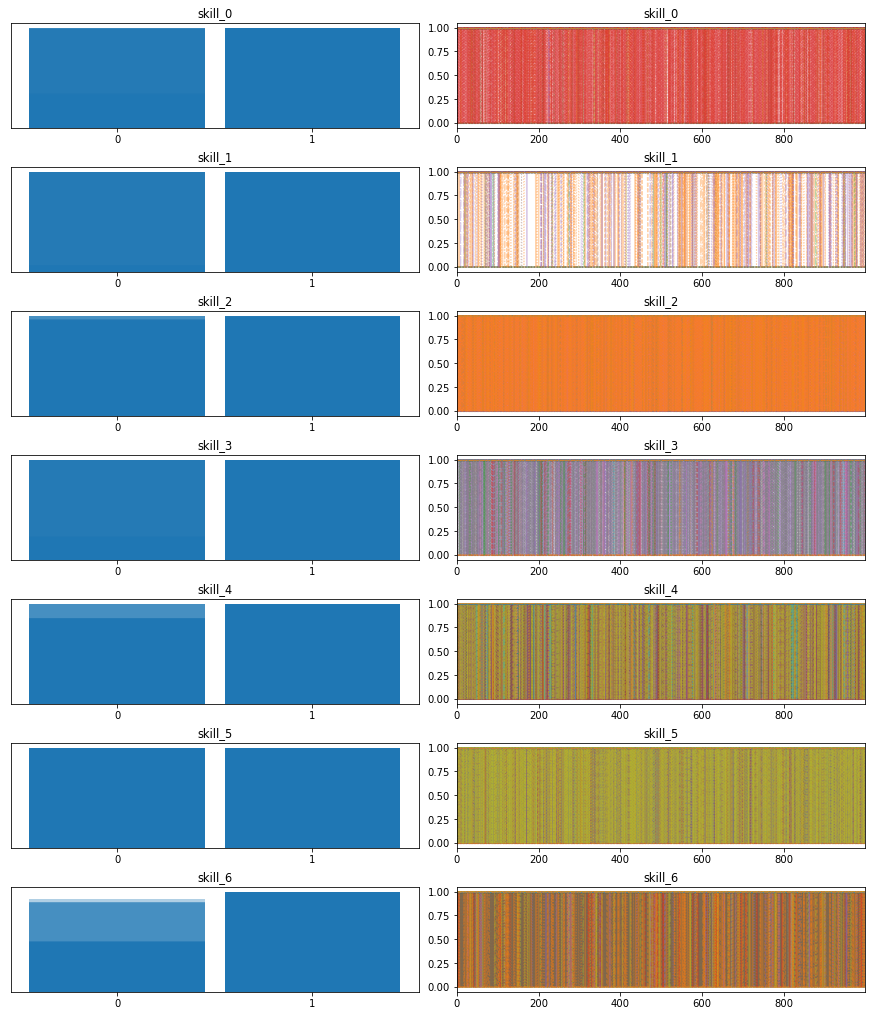

In [11]:
az.plot_trace(ds);

In [12]:
log_density_model_00, model_00_trace = log_density(
    model_00,
    (jnp.array(responses), skills_needed),
    dict(prob_mistake=0.1, prob_guess=0.2),
    {key: value.mean(0) for key, value in mcmc_00.get_samples().items()},
)
log_density_model_00

DeviceArray(-569.03217, dtype=float32)

In [13]:
def model_02(
    graded_responses, skills_needed: List[List[int]], prob_mistake=0.1,
):
    n_questions, n_participants = graded_responses.shape
    n_skills = max(map(max, skills_needed)) + 1

    with numpyro.plate("questions_plate", n_questions):
        prob_guess = numpyro.sample("prob_guess", dist.Beta(2.5, 7.5))

    participants_plate = numpyro.plate("participants_plate", n_participants)

    with participants_plate:
        skills = []
        for s in range(n_skills):
            skills.append(numpyro.sample("skill_{}".format(s), dist.Bernoulli(0.5)))

    for q in range(n_questions):
        has_skills = reduce(operator.mul, [skills[i] for i in skills_needed[q]])
        prob_correct = (
            has_skills * (1 - prob_mistake) + (1 - has_skills) * prob_guess[q]
        )
        isCorrect = numpyro.sample(
            "isCorrect_{}".format(q),
            dist.Bernoulli(prob_correct).to_event(1),
            obs=graded_responses[q],
        )

In [14]:
nuts_kernel = NUTS(model_02)

kernel = DiscreteHMCGibbs(nuts_kernel, modified=True)

mcmc_02 = MCMC(kernel, num_warmup=200, num_samples=1000, num_chains=4)
mcmc_02.run(
    rng_key,
    jnp.array(responses),
    skills_needed,
    extra_fields=(
        "z",
        "hmc_state.potential_energy",
        "hmc_state.z",
        "rng_key",
        "hmc_state.rng_key",
    ),
)
mcmc_02.print_summary()

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 1200/1200 [02:19<00:00,  8.61it/s, 7 steps of size 4.47e-01. acc. prob=0.86] 



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
 prob_guess[0]      0.26      0.12      0.25      0.05      0.43   3138.97      1.00
 prob_guess[1]      0.28      0.12      0.27      0.08      0.46   3689.75      1.00
 prob_guess[2]      0.32      0.13      0.31      0.10      0.51   5050.20      1.00
 prob_guess[3]      0.33      0.13      0.32      0.11      0.53   3007.40      1.00
 prob_guess[4]      0.29      0.12      0.28      0.09      0.48   2769.02      1.00
 prob_guess[5]      0.20      0.11      0.19      0.04      0.38   5336.04      1.00
 prob_guess[6]      0.39      0.13      0.39      0.18      0.60   4493.49      1.00
 prob_guess[7]      0.38      0.13      0.37      0.16      0.59   5009.81      1.00
 prob_guess[8]      0.39      0.13      0.38      0.17      0.59   3560.31      1.00
 prob_guess[9]      0.32      0.13      0.31      0.10      0.52   3133.14      1.00
prob_guess[10]      0.30      0.13      0.29      0.09      0.49

In [15]:
ds = az.from_numpyro(mcmc_02)

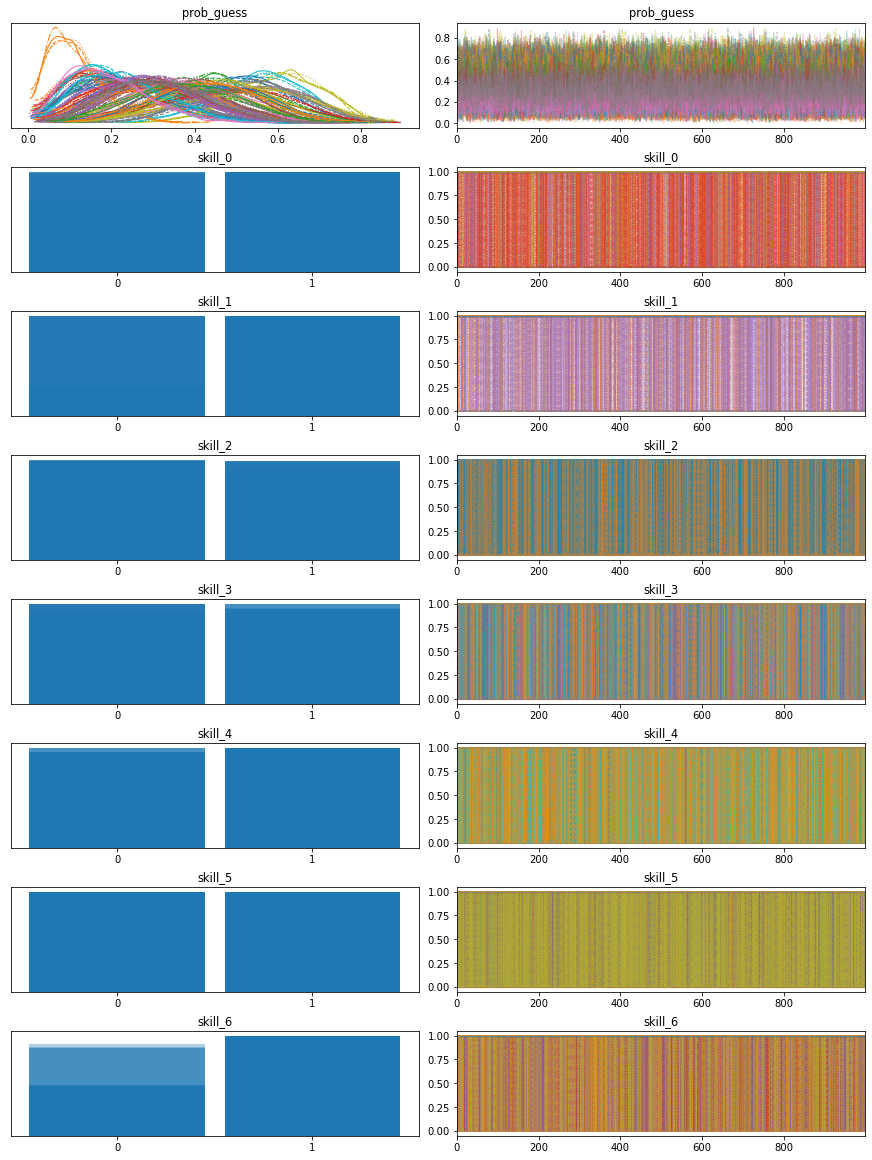

In [16]:
az.plot_trace(ds);

### Model Comparison

In [17]:
log_density_model_02, model_02_trace = log_density(
    model_02,
    (jnp.array(responses), skills_needed),
    dict(prob_mistake=0.1),
    {key: value.mean(0) for key, value in mcmc_02.get_samples().items()},
)
log_density_model_02

DeviceArray(-501.28668, dtype=float32)

In [18]:
pe_model_00 = mcmc_00.get_extra_fields()["hmc_state.potential_energy"]
pe_model_02 = mcmc_02.get_extra_fields()["hmc_state.potential_energy"]

print(
    "Expected log joint density of model_00: {:.2f} +/- {:.2f}".format(
        np.mean(-pe_model_00), np.std(-pe_model_00)
    )
)
print(
    "Expected log joint density of model_02: {:.2f} +/- {:.2f}".format(
        np.mean(-pe_model_02), np.std(-pe_model_02)
    )
)

Expected log joint density of model_00: -618.62 +/- 4.10
Expected log joint density of model_02: -652.77 +/- 7.04


<AxesSubplot:ylabel='negative Expected log density'>

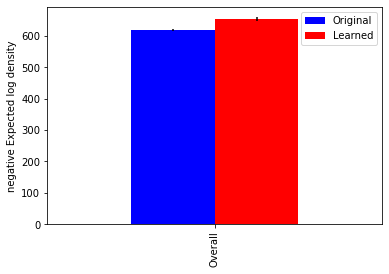

In [19]:
pd.DataFrame(
    np.array([np.mean(pe_model_00), np.mean(pe_model_02)])[None, :],
    columns=["Original", "Learned"],
    index=["Overall"],
).plot(
    kind="bar",
    color=["b", "r"],
    ylabel="negative Expected log density",
    yerr=[[np.std(pe_model_00)], [np.std(pe_model_02)]],
)

In [20]:
print(
    "Expected log joint density of model_00 from `log_density`: {:.2f}".format(
        log_density_model_00
    )
)
print(
    "Expected log joint density of model_02 from `log_density`: {:.2f}".format(
        log_density_model_02
    )
)

Expected log joint density of model_00 from `log_density`: -569.03
Expected log joint density of model_02 from `log_density`: -501.29


<AxesSubplot:ylabel='negative log density'>

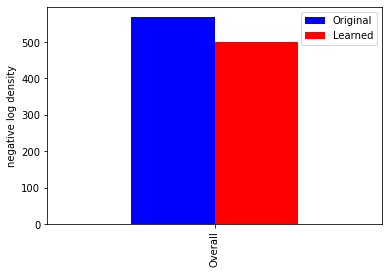

In [21]:
pd.DataFrame(
    -np.array([log_density_model_00, log_density_model_02])[None, :],
    columns=["Original", "Learned"],
    index=["Overall"],
).plot(kind="bar", color=["b", "r"], ylabel="negative log density")

#### **log_likelihood** 

signature: `log_likelihood(model, posterior_samples, *args, parallel=False, batch_ndims=1, **kwargs)`

* A good example of `log_likelihood` is from the [Example: Baseball Batting Average](http://num.pyro.ai/en/stable/examples/baseball.html#example-baseball-batting-average)
* The code below calculates the Log pointwise predictive density

In [22]:
post_loglik_00 = log_likelihood(model_00, mcmc_00.get_samples(), jnp.array(responses), skills_needed,)
post_loglik_00_res = np.concatenate([obs[:,None] for obs in post_loglik_00.values()],axis=1)
exp_log_density_00 = logsumexp(post_loglik_00_res, axis=0) - jnp.log(jnp.shape(post_loglik_00_res)[0])

In [23]:
post_loglik_02 = log_likelihood(model_02, mcmc_02.get_samples(), jnp.array(responses), skills_needed,)
post_loglik_02_res = np.concatenate([obs[:,None] for obs in post_loglik_02.values()],axis=1)
exp_log_density_02 = logsumexp(post_loglik_02_res, axis=0) - jnp.log(jnp.shape(post_loglik_02_res)[0])

<AxesSubplot:ylabel='Log pointwise predictive density'>

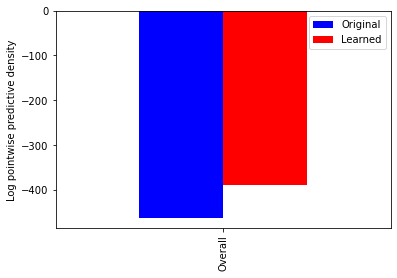

In [24]:
pd.DataFrame(
    np.array([np.sum(exp_log_density_00), np.sum(exp_log_density_02)])[None, :],
    columns=["Original", "Learned"],
    index=["Overall"],
).plot(
    kind="bar",
    color=["b", "r"],
    ylabel="Log pointwise predictive density",
)

#### Negative log probability of the ground truth

In [25]:
neg_log_proba_model_00 = neg_log_proba_score(
    mcmc_00.get_samples(),
    ["skill_" + str(i) for i in range(7)],
    self_assessed.values.T,
)

neg_log_proba_model_02 = neg_log_proba_score(
    mcmc_02.get_samples(),
    ["skill_" + str(i) for i in range(7)],
    self_assessed.values.T,
)

#### Figure 2.29(a)

<AxesSubplot:>

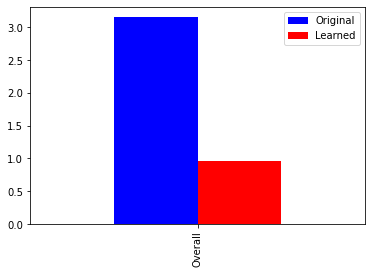

In [26]:
pd.DataFrame(
    np.array([neg_log_proba_model_00.mean(), neg_log_proba_model_02.mean()])[None, :],
    columns=["Original", "Learned"],
    index=["Overall"],
).plot(kind="bar", color=["b", "r"])

#### Figure 2.29(b)

<AxesSubplot:>

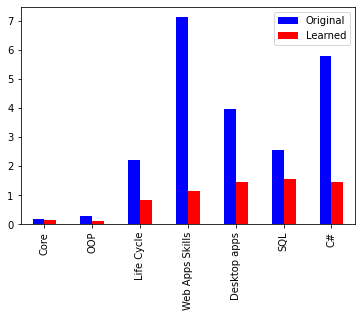

In [27]:
pd.DataFrame(
    np.concatenate(
        [
            neg_log_proba_model_00.mean(1)[:, None],
            neg_log_proba_model_02.mean(1)[:, None],
        ],
        axis=1,
    ),
    columns=["Original", "Learned"],
    index=["Core", "OOP", "Life Cycle", "Web Apps Skills", "Desktop apps", "SQL", "C#"],
).plot(kind="bar", color=["b", "r"])

### Odds and Ends
* failed attempts to reproduce the Figure 2.29
* read at your own peril

In [28]:
def get_proba(
    posterior_samples: Dict, params_sites: List[str], negative_log_proba=False
):
    """
    :param posterior_samples Dict: dictionary of samples from the posterior.
    :param params_sites List[str]: a list of params to compute proba
    :param negative_log_proba bool: flag to return either probability or negative log probability
    """
    proba = np.zeros((len(params_sites), posterior_samples[params_sites[0]].shape[-1]))
    for i, param in enumerate(params_sites):
        proba[i, :] = np.mean(posterior_samples[param], axis=0)

    if negative_log_proba:
        proba[proba == 0.0] = np.finfo(float).eps
        proba = -np.log(proba)

    return proba

In [29]:
self_assessed.astype(int).values.dtype

dtype('int64')

In [30]:
self_assessed.astype(int).values.T.shape

(7, 22)

In [31]:
proba = get_proba(
    mcmc_00.get_samples(),
    ["skill_" + str(i) for i in range(7)],
    negative_log_proba=False,
).T

In [32]:
proba.shape

(22, 7)

In [33]:
proba_00 = get_proba(
    mcmc_00.get_samples(),
    ["skill_" + str(i) for i in range(7)],
    negative_log_proba=False,
).T

rv_00 = scipy.stats.bernoulli(proba_00)

proba_model_00 = rv_00.pmf(self_assessed.astype(int).values)

proba_model_00[proba_model_00 == 0.0] = np.finfo(float).eps

neg_log_proba_model_00 = -np.log(proba_model_00)

(-np.log(proba_model_00)).mean()

3.15628763824813

In [34]:
proba_02 = get_proba(
    mcmc_02.get_samples(),
    ["skill_" + str(i) for i in range(7)],
    negative_log_proba=False,
).T

rv_02 = scipy.stats.bernoulli(proba_02)

proba_model_02 = rv_02.pmf(self_assessed.astype(int).values)

proba_model_02[proba_model_02 == 0.0] = np.finfo(float).eps

neg_log_proba_model_02 = -np.log(proba_model_02)

(-np.log(proba_model_02)).mean()

0.9652352227384892

<AxesSubplot:>

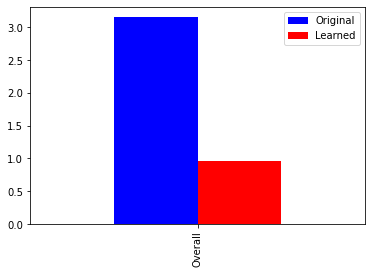

In [35]:
pd.DataFrame(
    np.array([neg_log_proba_model_00.mean(), neg_log_proba_model_02.mean()])[None, :],
    columns=["Original", "Learned"],
    index=["Overall"],
).plot(kind="bar", color=["b", "r"])

<AxesSubplot:>

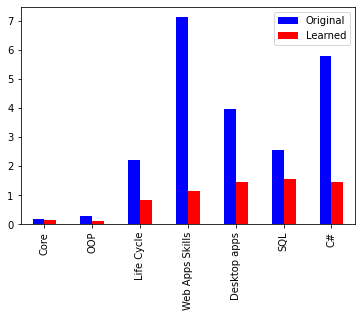

In [36]:
pd.DataFrame(
    np.concatenate(
        [
            neg_log_proba_model_00.mean(0)[:, None],
            neg_log_proba_model_02.mean(0)[:, None],
        ],
        axis=1,
    ),
    columns=["Original", "Learned"],
    index=["Core", "OOP", "Life Cycle", "Web Apps Skills", "Desktop apps", "SQL", "C#"],
).plot(kind="bar", color=["b", "r"])

In [37]:
-dist.Bernoulli(proba_02).log_prob(self_assessed.astype(int).values)

DeviceArray([[1.19209290e-07, 1.19209290e-07, 6.72364593e-01,
              6.60196126e-01, 5.03595257e+00, 5.00148453e-04,
              1.19209290e-07],
             [7.50286621e-04, 2.22456250e-02, 2.47991896e+00,
              4.84508336e-01, 9.73372310e-02, 1.17549435e-38,
              1.61343142e-01],
             [1.03028929e-02, 4.25905688e-03, 1.23256491e-02,
              4.89798278e-01, 6.70896530e-01, 1.24132860e+00,
              6.84187353e-01],
             [1.25081057e-03, 2.50013138e-04, 1.24146998e-01,
              3.12999904e-01, 4.31684963e-02, 1.75157762e+00,
              8.29412174e+00],
             [1.19209290e-07, 1.19209290e-07, 7.23091066e-01,
              1.13448694e-01, 5.24953175e+00, 2.33821225e+00,
              1.19209290e-07],
             [1.17549435e-38, 3.25529277e-03, 7.50281382e-04,
              2.50031269e-04, 1.00050040e-03, 1.17549435e-38,
              6.90650225e-01],
             [1.19209290e-07, 2.50013138e-04, 7.12839842e-01,
        

In [38]:
neg_log_proba_model_00 = get_proba(
    mcmc_00.get_samples(),
    ["skill_" + str(i) for i in range(7)],
    negative_log_proba=True,
).mean(1)

In [39]:
neg_log_proba_model_02 = get_proba(
    mcmc_02.get_samples(),
    ["skill_" + str(i) for i in range(7)],
    negative_log_proba=True,
).mean(1)

<AxesSubplot:>

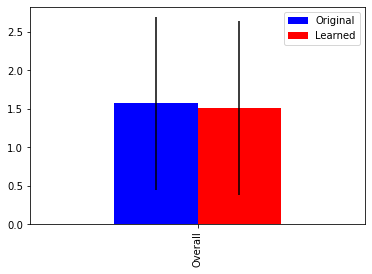

In [40]:
pd.DataFrame(
    np.array([neg_log_proba_model_00.mean(), neg_log_proba_model_02.mean()])[None, :],
    columns=["Original", "Learned"],
    index=["Overall"],
).plot(
    kind="bar",
    color=["b", "r"],
    yerr=[[neg_log_proba_model_00.std()], [neg_log_proba_model_02.std()]],
)

In [41]:
neg_log_proba_model_00_std = get_proba(
    mcmc_00.get_samples(),
    ["skill_" + str(i) for i in range(7)],
    negative_log_proba=True,
).std(1)

neg_log_proba_model_02_std = get_proba(
    mcmc_02.get_samples(),
    ["skill_" + str(i) for i in range(7)],
    negative_log_proba=True,
).std(1)

In [42]:
std = np.concatenate(
    [neg_log_proba_model_00_std[:, None], neg_log_proba_model_02_std[:, None]], axis=1
).T

<AxesSubplot:>

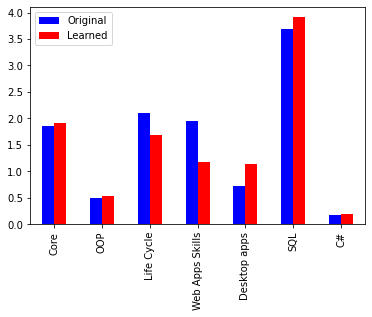

In [43]:
pd.DataFrame(
    np.concatenate(
        [neg_log_proba_model_00[:, None], neg_log_proba_model_02[:, None]], axis=1
    ),
    columns=["Original", "Learned"],
    index=["Core", "OOP", "Life Cycle", "Web Apps Skills", "Desktop apps", "SQL", "C#"],
).plot(kind="bar", color=["b", "r"])

<AxesSubplot:>

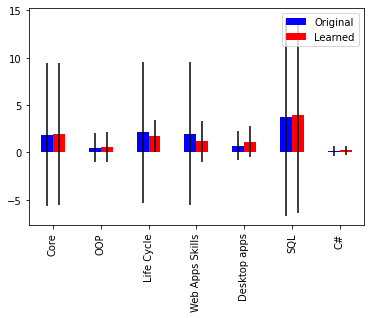

In [44]:
pd.DataFrame(
    np.concatenate(
        [neg_log_proba_model_00[:, None], neg_log_proba_model_02[:, None]], axis=1
    ),
    columns=["Original", "Learned"],
    index=["Core", "OOP", "Life Cycle", "Web Apps Skills", "Desktop apps", "SQL", "C#"],
).plot(kind="bar", color=["b", "r"], yerr=std)

In [45]:
[
    -np.log(mcmc_00.get_samples()[s].mean(0)).mean()
    for s in ["skill_" + str(i) for i in range(7)]
]

<ipython-input-45-9f20df540015>:2: RuntimeWarning: divide by zero encountered in log
  -np.log(mcmc_00.get_samples()[s].mean(0)).mean()


[inf, 0.4987566, inf, inf, 0.7172846, inf, 0.17295544]

In [46]:
res_00 = np.zeros((7, 22))
for i in range(7):
    s = "skill_" + str(i)
    res_00[i, :] = np.mean(mcmc_00.get_samples()[s], axis=0)

res_00[res_00 == 0.0] = np.finfo(float).eps

neg_log_proba_model_00 = (-np.log(res_00)).mean(1)

In [47]:
res_02 = np.zeros((7, 22))
for i in range(7):
    s = "skill_" + str(i)
    res_02[i, :] = np.mean(mcmc_02.get_samples()[s], axis=0)

res_02[res_02 == 0.0] = np.finfo(float).eps

neg_log_proba_model_02 = (-np.log(res_02)).mean(1)

In [48]:
np.array([(-np.log(res_00)).mean(), (-np.log(res_02)).mean()])[None, :]

array([[1.56985962, 1.5088825 ]])

In [49]:
np.finfo(float).eps

2.220446049250313e-16

<AxesSubplot:>

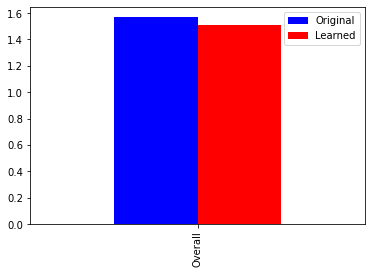

In [50]:
pd.DataFrame(
    np.array([(-np.log(res_00)).mean(), (-np.log(res_02)).mean()])[None, :],
    columns=["Original", "Learned"],
    index=["Overall"],
).plot(kind="bar", color=["b", "r"])

<AxesSubplot:>

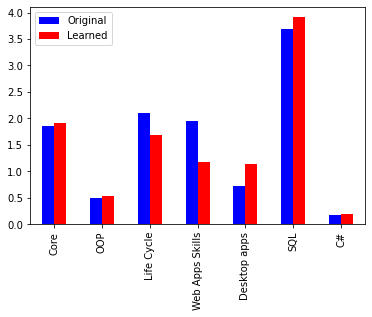

In [51]:
pd.DataFrame(
    np.concatenate(
        [neg_log_proba_model_00[:, None], neg_log_proba_model_02[:, None]], axis=1
    ),
    columns=["Original", "Learned"],
    index=["Core", "OOP", "Life Cycle", "Web Apps Skills", "Desktop apps", "SQL", "C#"],
).plot(kind="bar", color=["b", "r"])

In [52]:
[
    -np.log(mcmc_02.get_samples()[s].mean(0)).mean()
    for s in ["skill_" + str(i) for i in range(7)]
]

<ipython-input-52-ceafa89bc0dc>:2: RuntimeWarning: divide by zero encountered in log
  -np.log(mcmc_02.get_samples()[s].mean(0)).mean()


[inf, 0.5350453, 1.688612, 1.184382, 1.1330117, inf, 0.19561504]

In [53]:
neg_log_proba_model_00 = np.array(
    [
        -np.log(mcmc_00.get_samples()[s].mean(0).mean())
        for s in ["skill_" + str(i) for i in range(7)]
    ]
)

In [54]:
neg_log_proba_model_02 = np.array(
    [
        -np.log(mcmc_02.get_samples()[s].mean(0).mean())
        for s in ["skill_" + str(i) for i in range(7)]
    ]
)

<AxesSubplot:>

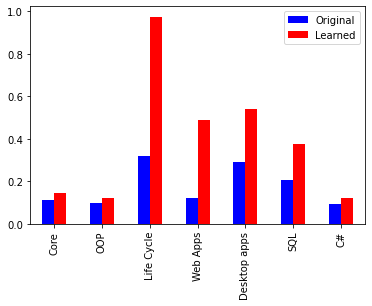

In [55]:
neg_log_proba_model_00 = np.array(
    [
        -np.log(mcmc_00.get_samples()[s].mean(0).mean())
        for s in ["skill_" + str(i) for i in range(7)]
    ]
)

neg_log_proba_model_02 = np.array(
    [
        -np.log(mcmc_02.get_samples()[s].mean(0).mean())
        for s in ["skill_" + str(i) for i in range(7)]
    ]
)


pd.DataFrame(
    np.concatenate(
        [neg_log_proba_model_00[:, None], neg_log_proba_model_02[:, None]], axis=1
    ),
    columns=["Original", "Learned"],
    index=["Core", "OOP", "Life Cycle", "Web Apps", "Desktop apps", "SQL", "C#"],
).plot(kind="bar", color=["b", "r"])